<a href="https://colab.research.google.com/github/ArtemNechaev/stepik_nnets/blob/main/task9_bert_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Определение эмоциональной окраски отзывов IMDB c помощью BERT

In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

## Установка библиотек

In [1]:
!pip install pytorch-transformers

In [2]:
import torch
from torchtext.datasets import IMDB
#from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

Tesla K80


## Загрузка данных


In [4]:
train_iter = IMDB(split='train')
test_iter = IMDB(split='test')

train_labels, train_texts = zip(*train_iter)
test_labels, test_texts = zip(*test_iter)
set(train_labels)

{'neg', 'pos'}

In [5]:
label2id = {'neg': 0, 'pos': 1}

## Inputs

BERTу нужно предоставить специальный формат входных данных.


- **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
- **labels**: вектор из нулей и единиц. В нашем случае нули обозначают негативную эмоциональную окраску, единицы - положительную.
- **segment mask**: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух: <length_of_sent_1> нулей и <length_of_sent_2> единиц.
- **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.

### Utils

In [7]:
def prepare_data(senteses, in_labels, max_sent_len = 200, max_num_subsent = 5):
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
  input_ids, labels, sent_ids = [], [], []
  for sent_id, (sent, label) in enumerate(zip(senteses, in_labels)):
    tokens = tokenizer.tokenize(sent)
    #if len(tokens) > max_sent_len:
    labels.append(label2id[label])
    sent_ids.append(sent_id)
    for i in range(0, max_sent_len*max_num_subsent, max_sent_len):
      input_ids.append(['[CLS]'] + tokens[i:i+max_sent_len] + ['[SEP]'])
      
    #else:
      #input_ids.append(['[CLS]'] + tokens + ['[SEP]'])
      #labels.append(label2id[label])
      #sent_ids.append(sent_id)

  input_ids = [tokenizer.convert_tokens_to_ids(s) for s in input_ids]
  input_ids = pad_sequences(
    input_ids,
    maxlen=max_sent_len + 2,
    dtype="long",
    truncating="post",
    padding="post"
  )
  attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

  input_ids = torch.tensor(input_ids).view(-1,max_num_subsent, max_sent_len + 2 )
  labels = torch.tensor(labels)
  attention_masks = torch.tensor(attention_masks).view(-1,max_num_subsent, max_sent_len + 2 )
  sent_ids = torch.tensor(sent_ids)

  dataset = TensorDataset(input_ids, attention_masks, labels, sent_ids)
  return dataset

In [8]:
def prepare_data2(senteses, in_labels, max_sent_len = 200, ):
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
  input_ids, labels, sent_ids = [], [], []
  for sent_id, (sent, label) in enumerate(zip(senteses, in_labels)):
    tokens = tokenizer.tokenize(sent)
    if len(tokens) > max_sent_len: 
      for i in range(0, max_sent_len*(len(tokens)//max_sent_len), max_sent_len):
        input_ids.append(['[CLS]'] + tokens[i:i+max_sent_len] + ['[SEP]'])
        labels.append(label2id[label])
        sent_ids.append(sent_id)  
    else:
      input_ids.append(['[CLS]'] + tokens + ['[SEP]'])
      labels.append(label2id[label])
      sent_ids.append(sent_id)

  input_ids = [tokenizer.convert_tokens_to_ids(s) for s in input_ids]
  input_ids = pad_sequences(
    input_ids,
    maxlen=max_sent_len + 2,
    dtype="long",
    truncating="post",
    padding="post"
  )
  attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

  input_ids = torch.tensor(input_ids)
  labels = torch.tensor(labels)
  attention_masks = torch.tensor(attention_masks)
  
  sent_ids = torch.tensor(sent_ids)

  dataset = TensorDataset(input_ids, attention_masks, labels, sent_ids)
  return dataset

### Подготовка данных

In [43]:
train_data = prepare_data2(train_texts, train_labels, max_sent_len = 300,)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=10
)

In [41]:
validation_data = prepare_data2(test_texts, test_labels, max_sent_len = 300, )
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=10
)

## Модели

Загружаем [BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129):

In [11]:
from pytorch_transformers import AdamW, BertForSequenceClassification

In [15]:
class Model(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
    self.loss_fn = torch.nn.CrossEntropyLoss()

  def forward(self, b_input_ids, b_input_mask, b_labels, b_sent_ids):
    #b_input_ids batch_size x max_len_subsent x max_sent_len
    max_len_subsent, max_sent_len = b_input_ids.shape[1], b_input_ids.shape[2]

    b_input_ids = b_input_ids.view(-1, max_sent_len) #batch_size * max_len_subsent x max_sent_len
    b_input_mask = b_input_mask.view(-1, max_sent_len)
    logits = self.bert(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = logits[0].view(-1, max_len_subsent, 2 ).mean(1)
    loss = self.loss_fn(logits, b_labels)
    if self.training:
      loss = self.loss_fn(logits, b_labels)
      return logits, loss
    else:
      return logits, b_labels, b_sent_ids

In [33]:
class Model2(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=50)
    self.ln = torch.nn.LayerNorm(50)
    self.fc = torch.nn.Linear(50,2)
    self.loss_fn = torch.nn.CrossEntropyLoss()

  def forward(self, b_input_ids, b_input_mask, b_labels, b_sent_ids):

    logits = self.bert(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = self.ln(logits[0])
    ind = b_sent_ids.argsort()
    logits = logits[ind]
    b_sent_ids = b_sent_ids[ind]
    b_labels = b_labels[ind]

    _ ,counts = b_sent_ids.unique(return_counts=True)
    counts = list(counts.cpu().numpy())
    ids = [sum(counts[:i]) for i in range(len(counts))]

    logits = torch.cat([t.mean(0, keepdim=True) for t in logits.split(counts)], )
    b_labels = b_labels[ids]
    b_sent_ids = b_sent_ids[ids]

    if self.training:
      loss = self.loss_fn(logits, b_labels)
      return logits, loss
    else:
      return logits, b_labels, b_sent_ids
    

    

## Обучение

In [44]:
model = Model2()
model.cuda()
print()

In [45]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()


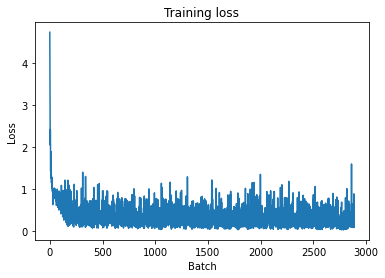

2887it [1:00:18,  1.25s/it]

Loss на обучающей выборке: 0.36402


In [46]:
from IPython.display import clear_output

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()


for step, batch in tqdm(enumerate(train_dataloader)):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    #b_input_ids, b_input_mask, b_labels, b_sent_ids = batch
    
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    
    # Forward pass
    logits, loss = model(*batch)

    train_loss_set.append(loss.item())  
    
    # Backward pass
    loss.backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss.item()
    
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))




In [47]:

# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels, valid_sent_ids = [], [], []

for batch in tqdm(validation_dataloader):   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    #b_input_ids, b_input_mask, b_labels, b_sent_ids = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits, b_labels, b_sent_ids = model(*batch)

        preds = logits.argmax(1).cpu().numpy()
        label_ids = b_labels.cpu().numpy()
        sent_ids = b_sent_ids.cpu().numpy()

    #batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(preds)
    valid_labels.extend(label_ids)
    valid_sent_ids.extend(sent_ids)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

100%|██████████| 2858/2858 [18:28<00:00,  2.58it/s]

Процент правильных предсказаний на валидационной выборке: 93.09%


In [51]:
_, ind = np.unique(valid_sent_ids, return_index=True)
print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(np.array(valid_labels)[ind], np.array(valid_preds)[ind])*100
))


Процент правильных предсказаний на валидационной выборке: 93.16%


# Вопросы

Используйте для дообучения BERT датасет IMDB. 

Ответьте на вопросы:
1. удалось ли достичь такого же accuracy (98\%) при использовании IMDB датасета?
2. удалось ли получить хорошее качество классификации всего за одну эпоху?
3. подумайте, в чем может быть причина различий в дообучении одной и той же модели на разных датасетах
    - Внимательно изучите датасет с русскими твитами. В чем его особенности? Нет ли явных паттернов или ключевых слов, которые однозначно определяют сентимент твита?
    - Попробуйте удалить пунктуацию из датасета с русскими твитами и перезапустите дообучение модели. Изменилось ли итоговое качество работы модели? Почему?

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [53]:
torch.save(model.state_dict(), 'drive/MyDrive/models/bert_IMDB_model2.pt')